# Long Short Term Memory (RNN) methods 

In [1]:
# Import libraries
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from keras.src.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import warnings


### Data Preprocessing 
#### Collect,sums up and clean the data (remove or insert 0 to any null values, visualise the data 
#### Adding and sorting the data based on date order, scaling the numerical values in suitable range (0 and 1), structuring data by creating sequences past values to be input and target being next value in sequences, and split data into 70% training set and 30% test set.

missing values in dataset: 
date         0
cases_new    0
dtype: int64
length of dataset:  1716
date         datetime64[ns]
cases_new             int64
dtype: object
            count                           mean                  min  \
date         1716  2022-05-31 12:00:00.000000256  2020-01-25 00:00:00   
cases_new  1716.0                    3097.769814                  0.0   

                           25%                  50%                  75%  \
date       2021-03-28 18:00:00  2022-05-31 12:00:00  2023-08-03 06:00:00   
cases_new                131.0                851.5               3246.5   

                           max          std  
date       2024-10-05 00:00:00          NaN  
cases_new              33406.0  5621.640214  
missing values in dataset: 
date         0
cases_new    0
dtype: int64


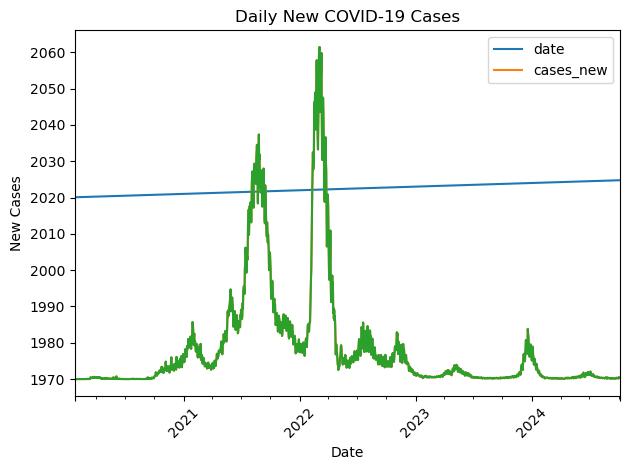

missing values in dataset: 
date         0
cases_new    0
dtype: int64


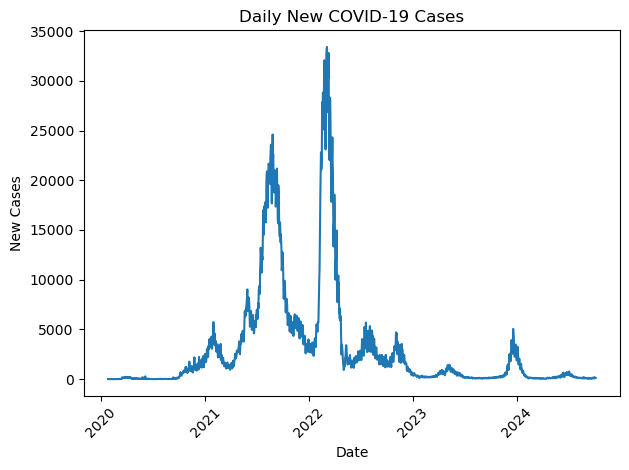

In [2]:
np.random.seed(1)
tf.random.set_seed(1) # same random number will be generated if put 1 
# Load the dataset
# Load the dataset, only columns date,state,new
# Load the dataset
df = pd.read_csv('../datasets/cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

# Set the frequency of the DataFrame's index to daily ('D')
df_grouped = df_grouped.asfreq('D')

# Check for missing values
print("missing values in dataset: ")
print(df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Check the length of the dataset
print("length of dataset: ", len(df_grouped))

#check df_grouped type of data for both columns
print(df_grouped.dtypes)

#calculate the mean,std, count, min, max, 25%,50%,75%
print(df_grouped.describe().transpose())
df_grouped.plot()
# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

# Check for missing values
print("missing values in dataset: ")
print(df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Plot the total new cases per day
plt.plot(df_grouped['date'], df_grouped['cases_new'])
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Daily New COVID-19 Cases')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()
# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

# Check for missing values
print("missing values in dataset: ")
print( df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Plot the total new cases per day
plt.plot(df_grouped['date'], df_grouped['cases_new'])
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Daily New COVID-19 Cases')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to avoid overlap
plt.show()

In [3]:
# Display the aggregated data
display(df_grouped.head(10))

# Get the total number of rows
total_rows = df_grouped.shape[0]
print("Total number of rows:", total_rows)

# sort by date order
df_grouped = df_grouped.sort_values(by='date')

#used to scale data into between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#drop date columns because it doesn't need to be scaled, just cases_new column only
scaled_data = scaler.fit_transform(df_grouped.drop(['date'], axis=1))

# Scaled data (Numpy array) is converted back into dataframe 
df_grouped_scaled = pd.DataFrame(scaled_data, columns=df_grouped.columns[1:])

#original 'date' is added back into new data frame 
df_grouped_scaled['date'] = df_grouped['date'].values

#convert data into suitable format for LSTM, sequence_length is for how many previous step model used to make predictions 
def reconstruct_data(data, sequence_length=5):
    X = [] #array of past sequence until current 
    y = [] #values of target variable [cases_new] at current value 
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  
    return np.array(X), np.array(y)

# Assuming 'cases_new' is the first column after the date column, scaled data is converted into Numpy array for easy manipulation 
data_for_lstm = df_grouped_scaled.drop(['date'], axis=1).values
# to prepare data for LSTM model , x is the input and y is the output 
X, y = reconstruct_data(data_for_lstm)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False) #shuffle is for data remains in chronological order



,date,cases_new
0,2020-01-25,4
1,2020-01-26,0
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
5,2020-01-30,1
6,2020-01-31,0
7,2020-02-01,0
8,2020-02-02,0
9,2020-02-03,0


Total number of rows: 1716


### LSTM Algorithms 
#### create the model architecture, train the data, evaluate test dataset , predicts using model and visualize the results, anaylze the results using MSE (Mean square Error) and MAE (Mean Absolute Error)
##### Notes
1) Adding more layers could make it learn complex patterns, however if it too much, it could lead to overfitting,longer time training
2) Adding a large value of dropout could lead to underfitting, because it fails to learn important patterns 
3) Training for 50 epochs may or may not be sufficient, depending on how well the model learns the patterns in the data. Monitor the loss values for the training and validation sets to decide if need to train for more or fewer epochs.
4) If the training loss is low, but the validation loss is high, the model might be overfitting. Adjusting dropout rates, reducing model complexity, or adding more data might help.
5) Smaller batch_sizes could lead to faster training, but less stable and bigger batch_sizes could make training smoother but slower

In [6]:
from keras.src.callbacks import EarlyStopping

#ignore the warning (gives because h5 file)
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.engine.training')

# Define the LSTM model
model = Sequential()

#have 2 hidden layers added in RNN
#units for 50 neuron in the layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #add the first layer 
model.add(Dropout(0.2))  # Helps prevent overfitting add neuron in hidden layer 
model.add(LSTM(units=128, return_sequences=False)) # add third LSTM layer, it is false because it is last hidden layer 
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer, single unit because wants to make prediction for single values 


# Using HDF5 format to save only the best model
cp = ModelCheckpoint('../models/LSTM_model1.h5', save_best_only=True)

# Compile the model, loss function: to calculate the difference between predicts and real using adam optimizer, its a must
# model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=MeanSquaredError())
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model architecture, print: numbers layer, output shape, total numbers parameter trained
model.summary()

# fit the train data into model, 
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #monitor based on MSE values to see the improvement
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, shuffle=False, callbacks=[cp, es])

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False, callbacks=[cp])
#epochs for how many times the model will see entire dataset, batch_size for how many samples it processes before updating weights. 



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
30

17/17 [==============================] - 0s 2ms/step - loss: 6.3063e-05
Test Loss: 6.306268187472597e-05
17/17 [==============================] - 0s 2ms/step


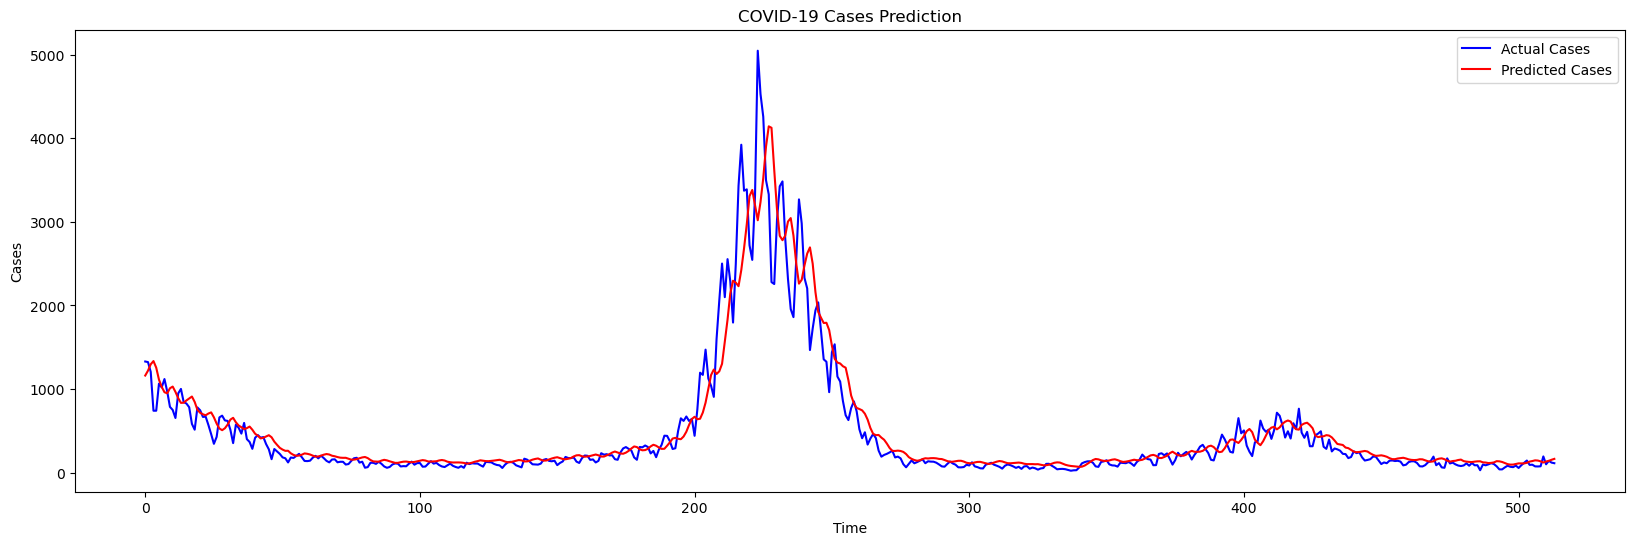

Mean Absolute Error (MAE): 127.93184118604846
Mean Squared Error (MSE): 6.306269554097398e-05
Root Mean Squared Error (MSE): 0.007941202398942743


In [7]:
#load model that is the best from h5 file to model1, to predict the value 
model1 = load_model('../models/LSTM_model1.h5')

# Evaluate the model on test data
loss = model1.evaluate(X_test, y_test)
print(f"Test Loss: {loss}") # lower loss values, better performance 

# Make predictions on the test set
y_pred = model1.predict(X_test) #generates predictions using trained model for the input data X_test

# Convert (inverse scale) the predictions and actual values back to their original scale.
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


# plot the graph for the 
plt.figure(figsize=(20, 6))
plt.plot(y_test_original, color='blue', label='Actual Cases')
plt.plot(y_pred_original, color='red', label='Predicted Cases')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Cases')
# # Formatting x-axis to show years
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Place ticks every year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to show year only
plt.legend()
plt.show()

# calculate to quantify model's performance and print the results 
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (MSE): {rmse}")


In [21]:
from keras.models import load_model

# Path to your saved model
saved_model_path = "../models/hybrid_model.keras"

# Load the model without compiling (ignoring the optimizer state)
modelhybrids = load_model(saved_model_path, compile=False)

modelhybrids.compile(optimizer='adam', loss='mean_squared_error')

print("Model loaded successfully!")


Model loaded successfully!
